In [1]:
import tensorflow as tf
import numpy as np
import math
from scipy.stats import ortho_group #generator for random orthogonal matrix
from time import time
#import math
##### sklearn
from sklearn.preprocessing import normalize
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.utils import gen_batches
from scipy.misc import face
face = face(gray=True)
##### plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

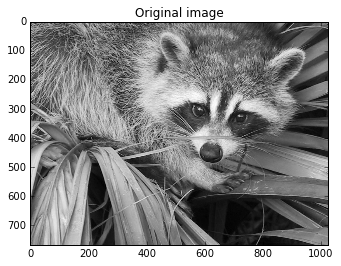

In [2]:
plt.imshow(face, cmap='gray')
plt.title('Original image')

In [3]:
# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::2, ::2] + face[1::2, ::2] + face[::2, 1::2] + face[1::2, 1::2]
face /= 4.0
im_height, im_width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, im_width // 2:] += 0.075 * np.random.randn(im_height, im_width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :im_width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
training_set = data.copy()
print('done in %.2fs.' % (time() - t0))

Distorting image...
Extracting reference patches...
done in 0.10s.


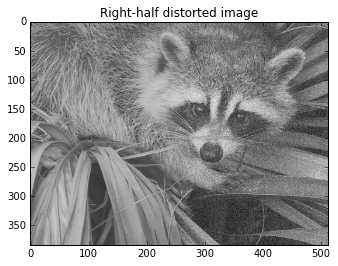

In [4]:
plt.imshow(distorted, cmap='gray')
plt.title('Right-half distorted image')

In [5]:
### Data generator from training set for autoencoder training

def batch_data_generator(training_data, batch_size):
    ## random mini-batching
    batch_idx_list = gen_batches(training_data.shape[0], batch_size)
    saved_idx_list = [batch_idx for batch_idx in batch_idx_list]
    return training_data[np.random.choice(saved_idx_list)]

def batch_data_generator_seq(training_data, batch_size, max_n_iters):
    ## sequential mini-batching
    #epoch_size = int(math.ceil(training_data.shape[0] / float(batch_size)))
    batch_idx_list = gen_batches(training_data.shape[0], batch_size)
    n0 = 0
    saved = list()
    
    for batch_idx in batch_idx_list:
        if n0 < max_n_iters:
            yield training_data[batch_idx]
            saved.append(batch_idx)
            n0 += 1
    #print('current counter value', n0)    
    if max_n_iters > n0:
        epoch_size = len(saved)
        while n0 < max_n_iters:
            yield training_data[saved[n0 % epoch_size]]
            n0 += 1
    #print('current counter value', n0)
    #print('max iter', max_n_iters)
         
def coding(weights, bias, test_data):
    codes = np.add(np.matmul(test_data, weights.T), bias)
    codes[codes <= 0] = 0
    return codes  
        


## Mini-batch dictionary learning ala sklearn

Learning the dictionary...
done in 5.34s.


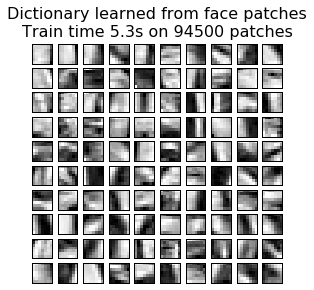

In [6]:
# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

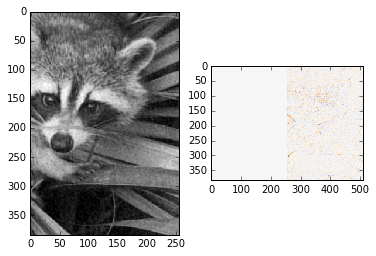

In [7]:
test_set = extract_patches_2d(distorted[:, im_width // 2:], patch_size)
test_set = test_set.reshape(test_set.shape[0], -1)
intercept = np.mean(test_set, axis=0)
test_set -= intercept

codes = dico.transform(test_set)
patches = np.dot(codes, V)
patches += intercept
patches = patches.reshape(len(test_set), *patch_size)
#patches -= patches.min()
#patches /= patches.max()
#im_height, im_width = face.shape
reconstructed = face.copy()
reconstructed[:, im_width // 2:] = reconstruct_from_patches_2d(patches, (im_height, im_width // 2))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(reconstructed[:, im_width//2:], vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest' )
plt.subplot(1,2,2)
difference = reconstructed - face.copy() 
plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest')
# plt.figure()
# for i in range(2):
#     plt.subplot(1,2,i+1)
#     if i == 0:
#         plt.imshow(face.copy()[:,:width//2], cmap='gray')
#     else:
#         plt.imshow(reconstructed[:,width//2:], cmap='gray')       

## ReLu activated two-layer autoencoder  

In [42]:
## define bias initialization
def bias_init(weights, norm, batch_data):
    #assert norm > 1, 'the norm value is invalid!'
    ## calculate average inner product
    proj = np.matmul(weights, np.transpose(np.array(batch_data)))
    proj[proj<=0] = 0
    proj[proj>0] = 1
    avg_proj = np.mean(proj, axis=1)
    return np.subtract(np.divide(avg_proj, norm**2), avg_proj)

## evaluation metric
def cosine_squared_distances(weights, dictionary):
    #print(weights.shape)
    #print(normalize(weights))
    w_normalized = normalize(weights)
    #w_normalized = 0.5*weights
    #raw_scores = np.square(np.matmul(w_normalized, np.transpose(dictionary)))
    raw_scores = np.square(np.matmul(w_normalized, dictionary))
    max_scores = np.max(raw_scores, axis=0) # best approximation for each dict item
    #return max_scores, raw_scores, min(max_scores)
    return max_scores
def cos_sq_avg_distances(weights, dictionary):
    #max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = cosine_squared_distances(weights, dictionary)
    max_scores = [1]*len(max_scores)-max_scores
    return np.mean(max_scores)
def cos_sq_min_distances(weights, dictionary):
    #max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = cosine_squared_distances(weights, dictionary)
    max_scores = [1]*len(max_scores)-max_scores
    return np.max(max_scores)


########
#### Experimental aide
def get_firing_pattern_op(firing_list, weights, bias, batch_data):
    ## get statistics about average firing intensity of each neuron
    firing = np.transpose(np.matmul(weights, np.transpose(batch_data)))+bias
    firing[firing<=0] = 0
    firing[firing>0] = 1
    firing = np.mean(firing, axis=0)
    firing_list.append(firing)

def get_bias_evolution_op(b_list, bias):
    ## update b_list to record current bias values
    b_list.append(bias)

def get_norm_evolution_op(weights_list, weights):
    weights_list.append(np.linalg.norm(weights))

In [43]:
## network parameters
width = 225
dim = patch_size[0] * patch_size[1]
activation = 'relu'

## get initial weights
init_weights = tf.random_normal([width, dim], dtype=tf.float64) # init random weights
init_batch = batch_data_generator(training_set, 1)
for _ in range(width-1):
    init_batch = np.concatenate([init_batch, batch_data_generator(training_set, 1)], axis=0)
#init_weights = tf.constant(np.array(init_batch), dtype=tf.float64)
# init_weights = tf.constant(batch_data_generator(dim, noise_bound, width, dict_type, dict_size, gt_dict), 
#                                dtype=tf.float64)
#batch_data = batch_data_generator(training_set, init_batch_size)
with tf.Session() as sess:
    init_weights_ = sess.run(init_weights)
    #init_weights_ = init_weights
    #init_bias_ = sess.run(init_bias)
init_bias_ = bias_init(init_weights_, norm, init_batch)


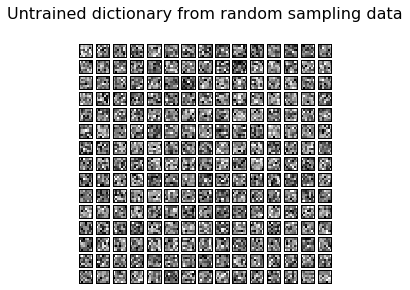

In [44]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(init_weights_):
    plt.subplot(15, 15, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Untrained dictionary from random sampling data',
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

### Original SGD Training

In [45]:
## algorithmic parameters
init_batch_size = 1000
norm = 2
#norm = 0.8
#rescale_param = 1/float(norm**2) - 1
# t_o = 2000
# c_prime = 200
t_o = 100
c_prime = 1
##
train_steps = 1000

In [46]:
## Relu - autoencoder model with tied weights

### parameters to learn
weights = tf.Variable(init_weights_, dtype=tf.float64)
#bias = tf.Variable(init_bias_, dtype=tf.float64)
bias = tf.Variable(np.zeros(width), dtype=tf.float64, trainable=False)
create_row_normalize_op = tf.assign(weights, norm * tf.nn.l2_normalize(weights, dim=1))
### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.matmul(tf.nn.relu(h), weights)
    else:
        print('activation function not implemented')
        exit(0)

###
def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))

#x_gt = tf.placeholder(tf.float64, [dim,])
mini_batch_size = 100
batch_x = tf.placeholder(tf.float64, [mini_batch_size, dim])

### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = tf.Variable(0.001, dtype='float64', trainable=False)
init_eval_batch = batch_data_generator(training_set, 100)
init_eval_batch = np.array(init_eval_batch, dtype='float64')
init_loss = data_wise_mean_sq_loss(init_eval_batch, init_weights_, 0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_loss_ = init_loss.eval()
    
loss = tf.Variable(init_loss_, trainable=False)
update_loss_op = tf.assign(loss, data_wise_mean_sq_loss(batch_x, weights, bias))
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(data_wise_mean_sq_loss(batch_x, weights, bias))

In [47]:
## standard learning-rate decayed SGD training

create_row_normalize_op = tf.assign(weights, tf.nn.l2_normalize(weights, dim=1))
# eta = 0.1
# update_bias_op = tf.assign(bias, 
#                     bias*(1-eta)+eta*tf.squeeze(tf.matmul(weights, tf.expand_dims(x_gt, axis=1)))*rescale_param)

#gt_dict = ortho_group.rvs(dim) # generate ground-truth dictionary
#test_sample = batch_data_generator(dim, noise_bound, 100)
avg_scores_list = list()
losses_list = list()
learn_rate_list = list()
control_weight = False
verbose = False
batches = batch_data_generator_seq(training_set, mini_batch_size, train_steps)
for n_runs in range(1):
    bias_list = [np.zeros(width)]
    avg_scores = list()
    #firing_list = list()
    losses = [init_loss_]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i, batch in enumerate(batches):
        #i = 0
        #while i < train_steps:
            batch = batch_data_generator(training_set, mini_batch_size)
            if batch.shape[0] != mini_batch_size:
                continue
            #if i==0:
                #avg_scores.append(cos_sq_avg_distances(init_weights_, gt_dict))
                #get_firing_pattern_op(firing_list, init_weights_, init_bias_, x)    
            _, weights_, bias_, learn_rate_ = sess.run([train_op, weights, bias, learn_rate], feed_dict={batch_x: batch})
            if control_weight:
                ## normalize weight if control_weight is on
                _, weights_ = sess.run([create_row_normalize_op, weights]) 
            _, loss_ = sess.run([update_loss_op, loss], feed_dict={batch_x: batch})
            n_steps_ ,learn_rate_ = sess.run([increment_global_step_op, learn_rate])
            #print('reconstruction error', cos_sq_avg_distances(weights_, gt_dict))
            #avg_scores.append(cos_sq_avg_distances(weights_, gt_dict))
            #get_firing_pattern_op(firing_list, weights_, bias_, x)
            get_bias_evolution_op(bias_list, bias_)
            losses.append(loss_)
            if verbose and ((n_steps_-t_o) % 100 == 0):
                print('Training at %d-th iteration'% (n_steps_-t_o))
                print('Training objective loss', loss_)
                #print('Dictionary approximation distance', cos_sq_avg_distances(weights_, gt_dict))
            learn_rate_list.append(learn_rate_)
            #i += 1
        avg_scores_list.append(avg_scores)
        losses_list.append(np.array(losses))
        #weights_final = weights_.eval()
        #bias_final = bias_.eval()
    #print('Cosine best approximation distance at init', cosine_squared_distances(init_weights_, gt_dict)[0])
    #print('Cosine best approximation after updates', cosine_squared_distances(weights_, gt_dict)[0])

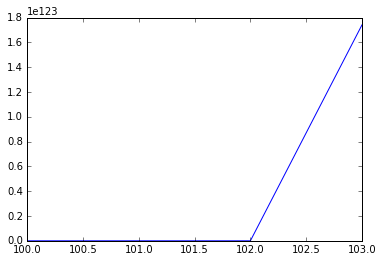

In [48]:
time_pts = range(t_o, t_o+train_steps+1)
# print(cos_sq_avg_distances(init_weights_, gt_dict))
loss_graph = np.mean(np.array(losses_list), axis=0)
plt.plot(time_pts, loss_graph)
#loss_graph[200]

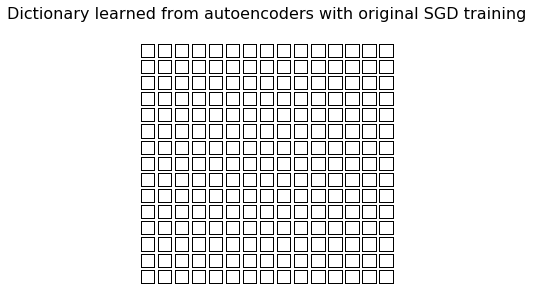

In [49]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(weights_):
    plt.subplot(15, 15, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from autoencoders with original SGD training',
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

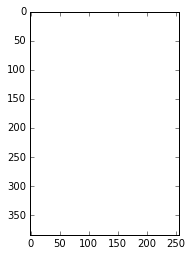

In [50]:
test_set = extract_patches_2d(distorted[:, im_width // 2:], patch_size)
test_set = test_set.reshape(test_set.shape[0], -1)
intercept = np.mean(test_set, axis=0)
test_set -= intercept

codes = coding(init_weights_, init_bias_, test_set)
patches = np.dot(codes, weights_)
patches += intercept
patches = patches.reshape(len(test_set), *patch_size)
patches -= patches.min()
patches /= patches.max()
#im_height, im_width = face.shape
reconstructed = face.copy()
reconstructed[:, im_width // 2:] = reconstruct_from_patches_2d(patches, (im_height, im_width // 2))
plt.imshow(reconstructed[:, im_width//2:], vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest' )
#difference = reconstructed - face.copy() 
#plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest')
# plt.figure()
# for i in range(2):
#     plt.subplot(1,2,i+1)
#     if i == 0:
#         plt.imshow(face.copy()[:,:width//2], cmap='gray')
#     else:
#         plt.imshow(reconstructed[:,width//2:], cmap='gray')

## Modified SGD Training

In [51]:
## algorithmic params
init_batch_size = 1000
norm = 1
#norm = 0.8
#rescale_param = 1/float(norm**2) - 1
# t_o = 2000
# c_prime = 200
##
train_steps = 1000
mini_batch_size = 5
b_appx_batch_size = 100
t_o = 100
c_prime = 20
weights_all = list()
tf.reset_default_graph()

In [52]:
## Relu - autoencoder model with tied weights

### parameters to learn
#init_weights = tf.random_normal([width, dim], dtype=tf.float64)
weights = tf.Variable(init_weights_, name='weights_mod', dtype=tf.float64)
bias = tf.Variable(init_bias_, trainable=False, dtype=tf.float64)
#bias = tf.Variable(np.zeros(width), name = 'bias_mod', trainable=True, dtype=tf.float64)

### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.matmul(tf.nn.relu(h), weights)
    else:
        print('activation function not implemented')
        exit(0)

def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))

# def batch_wise_mean_sq_loss(batch_x, weights, bias):
#     batch_x_hat = decoder(weights, encoder(weights, bias, batch_x), 'relu')
#     print(batch_x_hat.get_shape())
#     return tf.reduce_mean(tf.square(batch_x - batch_x_hat), axis=1)

#x_gt = tf.placeholder(tf.float64, [dim,])
batch_x_gt = tf.placeholder(tf.float64, [mini_batch_size, dim])
batch_x_update_b = tf.placeholder(tf.float64, [b_appx_batch_size, dim])
### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
rescale_param = tf.Variable(1/float(norm**2) - 1, trainable=False, dtype=tf.float64)
####
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = 0.1
#init_eval_batch = batch_data_generator(dim, noise_bound, 100, dict_type, dict_size, gt_dict)
init_eval_batch = batch_data_generator(training_set, 100)
init_eval_batch = np.array(init_eval_batch, dtype='float64')
init_loss = data_wise_mean_sq_loss(init_eval_batch, init_weights_, 0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_loss_ = init_loss.eval()
    
loss = tf.Variable(init_loss_, trainable=False)
update_loss_op = tf.assign(loss, data_wise_mean_sq_loss(batch_x_gt, weights, bias))
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(data_wise_mean_sq_loss(batch_x_gt, weights, bias))

In [53]:
## Norm-controlled SGD training
norm_decay_rate = tf.train.inverse_time_decay(tf.cast(1, tf.float64), 
                                              tf.subtract(global_step, t_o), decay_steps, decay_rate)

create_row_normalize_op = tf.assign(weights, (1+norm_decay_rate) * tf.nn.l2_normalize(weights, dim=1))
#update_rescale_param_op = tf.assign(rescale_param, 1/(1+norm_decay_rate)**2 - 1)
# create_row_normalize_op = tf.assign(weights, (1+1) * tf.nn.l2_normalize(weights, dim=1))
update_rescale_param_op = tf.assign(rescale_param, 1/(1+1)**2 - 1)

##########################
def get_bias_update(weights_new, bias, rescale_param, batch_x, learning_rate=0.001):
    batch_x = np.array(batch_x)
    hidden = np.transpose(np.add(np.transpose(np.matmul(weights_new, batch_x.T)), bias))
    hidden[hidden>0] = 1
    hidden[hidden<=0] = 0
    projection = np.matmul(weights_new, batch_x.T)
    bias_new = np.mean(np.multiply(projection, hidden), axis=1)
    return np.add((1.0-learning_rate)*bias, learning_rate*bias_new*rescale_param)
    #return bias_new * rescale_param

def reinitialize_weights(weights, bias, batch_x, gt_dict, dim, noise_bound, dict_type, dict_size):
    batch_x = np.array(batch_x)
    hidden = np.transpose(np.add(np.transpose(np.matmul(weights, batch_x.T)), bias))
    hidden[hidden>0] = 1
    hidden[hidden<=0] = 0
    ####
    firing_prob = np.mean(hidden, axis=1)
    ind = firing_prob <= 0.8
    data_raw = batch_data_generator(dim, noise_bound, np.sum(ind), dict_type, dict_size, gt_dict)
    data_norms = np.linalg.norm(data_raw, axis=1)
    ## normalize data
    weights[ind] = np.transpose(np.multiply(np.transpose(data_raw), data_norms))
    return weights
    

#new_bias = get_bias_update(batch_x_update_b, weights, bias, width, b_appx_batch_size, rescale_param)
#update_bias_op = tf.assign(bias, new_bias)
### Define some handy operations to update network variables
bias_new = tf.placeholder(tf.float64, [width])
update_bias_op = tf.assign(bias, bias_new)
###
weights_new = tf.placeholder(tf.float64, [width, dim])
update_weights_op = tf.assign(weights, weights_new)



#test_sample = batch_data_generator(dim, noise_bound, 100)

#min_scores_mod = list()
#weights_cache = init_weights_
#bias_cache = init_bias_
avg_scores_mod_list = list()
losses_mod_list = list()
control_norm = True
control_bias = True
reassign_weights = False
##### Training
for n_runs in range(1):
    avg_scores_mod = list()
    losses_mod = [init_loss_]
    #firing_list_mod = list()
    bias_list_mod = [init_bias_]
    weights_cached = init_weights_
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        i = 0
        while i < train_steps:
            batch_x = batch_data_generator(training_set, mini_batch_size)
            if batch_x.shape[0] != mini_batch_size:
                continue
            _, weights_, bias_ = sess.run([train_op, weights, bias] , feed_dict={batch_x_gt: batch_x})
            n_steps, learn_rate_ = sess.run([increment_global_step_op, learn_rate])
            
            #if reassign_weights:
            #    weights_ = reinitialize_weights(weights_, bias_, batch_x, gt_dict, dim, 
            #                                         noise_bound, dict_type, dict_size)
            #    _, weights_ = sess.run([update_weights_op, weights], feed_dict={weights_new: weights_})
            
            if control_norm:
                _,weights_ = sess.run([create_row_normalize_op, weights])  ## row-normalization of updated weights
            
            if control_bias:
                batch_x_new = batch_data_generator(training_set, b_appx_batch_size)
                _, rescale_param_ = sess.run([update_rescale_param_op, rescale_param])
                #bias_ = get_bias_update(weights_, weights_cached, bias_, rescale_param_, batch_x_new)
                bias_ = get_bias_update(weights_, bias_, rescale_param_, batch_x_new, learn_rate_)
                _,_ = sess.run([update_bias_op, bias], feed_dict={bias_new: bias_})
                weights_cached = weights_
            
            _, loss_ = sess.run([update_loss_op, loss], feed_dict={batch_x_gt: batch_x})
            ## get a fresh sample and update bias
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            #bias_ = sess.run(update_bias_op, feed_dict={x_gt: x})  ## update bias using updated weights
            #batch_x_for_b = batch_data_generator(dim, noise_bound, b_appx_batch_size, gt_dict)
            #_, bias_ = sess.run([update_bias_op, bias],feed_dict={batch_x_update_b: np.array(batch_x_for_b)})
            #print('bias norm', np.sum(np.square(bias_))**0.5)
            
            losses_mod.append(loss_)
            #min_scores_mod.append(cos_sq_min_distances(weights_, gt_dict))
            get_bias_evolution_op(bias_list_mod, bias_)
            #get_firing_pattern_op(firing_list_mod, weights_, bias_, batch_x)
            i += 1
    losses_mod_list.append(np.array(losses_mod))
#         if (n_steps-t_o) % 100 == 0:
#             print('Training at %d-th iteration'% (n_steps-t_o))
#             print('cosine distances',)
#             print(cosine_squared_distances(weights_, gt_dict)[0])
#             #print('number of bias entries not updated is %d'%len(ind_))
#             print('change of weights', sess.run(tf.norm(weights_ - weights_cache)))
#             #print('change of bias', tf.norm(bias_ - bias_cache))
#             weights_cache = weights_
            #bias_cache = bias_
    #weights_final = weights_.eval()
    #bias_final = bias_.eval()

In [54]:
len(losses_mod_list[0])

1001

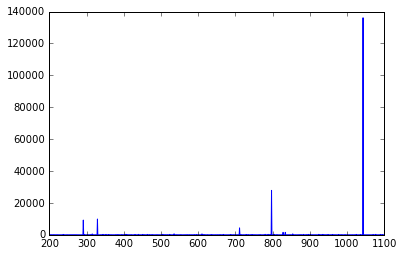

In [55]:
time_pts = range(t_o, t_o+train_steps+1)
loss_graph = np.mean(np.array(losses_mod_list), axis=0)
plt.plot(time_pts[100:], loss_graph[100:])

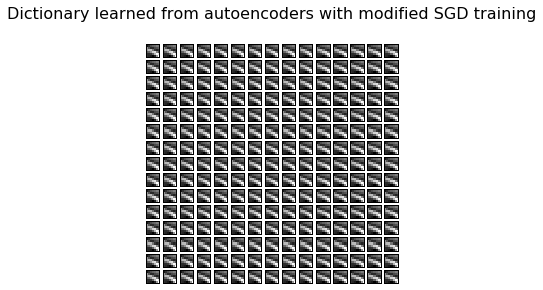

In [56]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(weights_):
    plt.subplot(15, 15, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from autoencoders with modified SGD training',
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

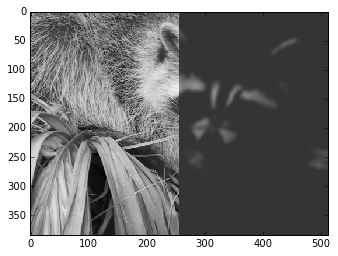

In [57]:
test_set = extract_patches_2d(distorted[:, im_width // 2:], patch_size)
test_set = test_set.reshape(test_set.shape[0], -1)
intercept = np.mean(test_set, axis=0)
test_set -= intercept

codes = coding(weights_, bias_, test_set)
patches = np.dot(codes, weights_)
patches += intercept
patches = patches.reshape(len(test_set), *patch_size)
patches -= patches.min()
patches /= patches.max()
#height, width = face.shape
reconstructed = face.copy()
reconstructed[:, im_width // 2:] = reconstruct_from_patches_2d(patches, (im_height, im_width // 2))
plt.imshow(reconstructed, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest' )
# plt.figure()